# Topic Modeling (LDA)

## Importo paquetes


In [1]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# creo una lista con las stopwords en español
spanish_stop_words = list(STOP_WORDS)

/home/kevin/.pyenv/versions/3.9.15/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargo base de datos

In [2]:
dataset = load_dataset("mrm8488/CHISTES_spanish_jokes")
dataset['train'][0]

#convierto a pandas conservando el nombre de las columnas
df = pd.DataFrame(dataset['train'])

In [3]:
df

,id,text,keywords,funny,category
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros
...,...,...,...,...,...
2414,2414,Una mujer en la consulta del médico.\n-Hola do...,"doctor,ropa",2,profesiones
2415,2415,Error 0094782: No se detecta ningún teclado pu...,"windows,teclado",2,tematicos
2416,2416,Una chica entra a una iglesia con un buen esco...,"escote,pecho,cura",2,tematicos
2417,2417,Un hombre va a hablar con su jefe:\n-Hola veng...,"boda,jefe",2,familia


## Analisis de la base de datos

In [4]:
# cuantas categorias hay
df['category'].value_counts()

category
otros          770
familia        580
sexo           353
animales       229
profesiones    199
regionales     194
tematicos       94
Name: count, dtype: int64

In [5]:
df['category'].value_counts()/df.shape[0]

category
otros          0.318313
familia        0.239768
sexo           0.145928
animales       0.094667
profesiones    0.082265
regionales     0.080198
tematicos      0.038859
Name: count, dtype: float64

Así tenemos 7 categorías, siendo la más común 'otros' con un 31,8%. Exploremos también el tamaño de los chistes.

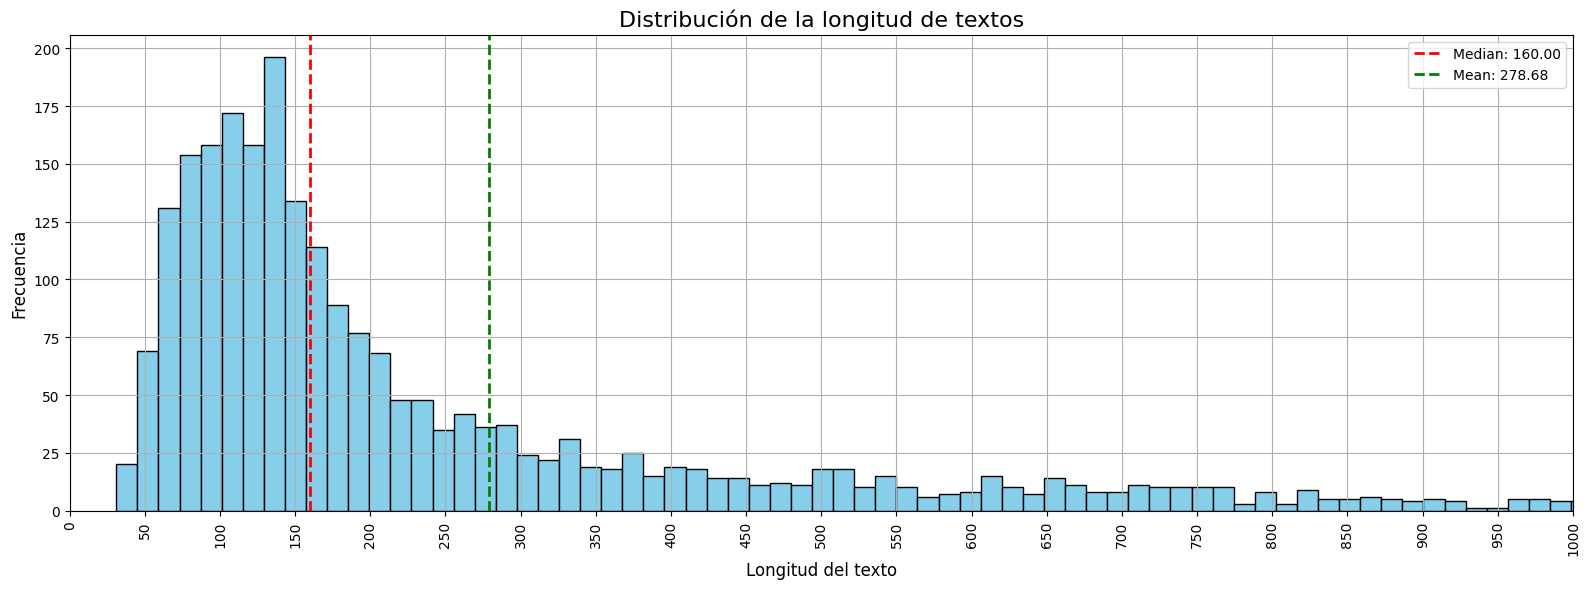

In [6]:
# Crear la columna 'len' (asegúrate de que este paso se ejecute primero)
df['len'] = df['text'].apply(lambda t: len(t))

# Ahora, puedes proceder a graficar
plt.figure(figsize=(16, 6))

# Histograma
df['len'].hist(bins=200, color='skyblue', edgecolor='black')
plt.xticks(range(0, 2000, 50), rotation=90)
plt.xlim((0, 1000))

# Líneas de la mediana y la media
median_value = df['len'].median()
mean_value = df['len'].mean()
plt.axvline(median_value, color='r', linestyle='dashed',
            linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(mean_value, color='g', linestyle='dashed',
            linewidth=2, label=f'Mean: {mean_value:.2f}')

# Etiquetas y título
plt.title('Distribución de la longitud de textos', fontsize=16)
plt.xlabel('Longitud del texto', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

La mitad de los chistes tienen un tamaño inferior a 160 caracteres

In [7]:
df['Palabras por chiste'] = df['text'].str.split().apply(len)
df['Palabras por chiste'].median()

31.0

Aquí podemos observar que la mediana de longitud en terminos de palabras es de 31. Esto es esperado, pues los chistes deben ser cortos por naturaleza. Por otra parte, es bastante claro que el corpus original del modelo pre-entrenado contenía texto muy diferente a este, por lo que la calidad de los resultados, sin hacer mayores modificaciones puede que no sea buena

# Modelo de clustering


In [8]:
# Preprocesamiento del texto (ejemplo simplificado)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

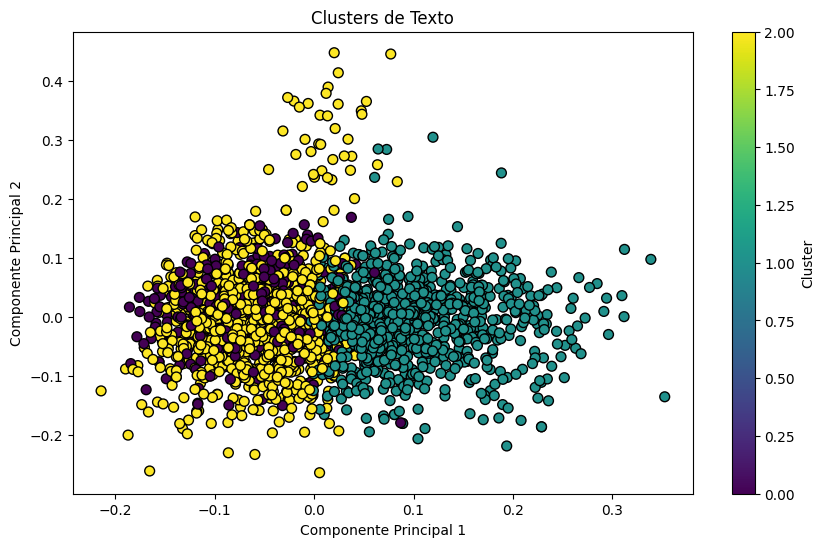

In [9]:
# Suponiendo que ya tienes df con los clusters
# Reducir la dimensionalidad
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Agregar las coordenadas reducidas al DataFrame
df['x'] = X_reduced[:, 0]
df['y'] = X_reduced[:, 1]

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'],
            cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters de Texto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# veo palabras de cada clusters
# Obtener el vocabulario
words = vectorizer.get_feature_names_out()

# Crear un DataFrame para almacenar las palabras más importantes
important_words = {}

# Iterar sobre cada cluster
for cluster in range(kmeans.n_clusters):
    # Sumar los vectores TF-IDF de los documentos en este cluster
    cluster_docs = X[df['cluster'] == cluster]
    cluster_mean = np.mean(cluster_docs.toarray(), axis=0)

    # Obtener las palabras con el mayor valor en el vector promedio
    # 10 palabras más importantes
    top_indices = cluster_mean.argsort()[-10:][::-1]
    important_words[cluster] = [(words[i], cluster_mean[i])
                                for i in top_indices]

# Mostrar las palabras más importantes de cada cluster
for cluster, words in important_words.items():
    print(f'Cluster {cluster}:')
    for word, score in words:
        print(f'  {word}: {score:.4f}')

Cluster 0:
  qué: 0.1148
  por: 0.0490
  un: 0.0444
  en: 0.0394
  de: 0.0374
  los: 0.0365
  que: 0.0314
  porque: 0.0307
  la: 0.0299
  no: 0.0295
Cluster 1:
  el: 0.0984
  la: 0.0849
  que: 0.0806
  de: 0.0774
  le: 0.0729
  un: 0.0639
  en: 0.0538
  se: 0.0531
  dice: 0.0449
  al: 0.0439
Cluster 2:
  que: 0.0437
  de: 0.0423
  no: 0.0379
  la: 0.0374
  el: 0.0347
  me: 0.0303
  se: 0.0301
  un: 0.0300
  es: 0.0289
  una: 0.0261


son stops word, por lo que no aportan información relevante para el modelo. Por lo tanto, se procede a eliminarlas.

In [11]:
def preprocess_text(text):
    # Aquí puedes agregar más pasos de limpieza si es necesario
    text = text.lower()  # Convertir a minúsculas
    # ... (eliminar puntuación, etc.)
    return text


df['cleaned_text'] = df['text'].apply(preprocess_text)

# Usar TfidfVectorizer con stop words en español
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X = vectorizer.fit_transform(df['cleaned_text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

# (Opcional) Mostrar los clusters
print(df[['text', 'cluster']])

                                                   text  cluster
0     - ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...        2
1     - ¿Cuál es el mejor portero del mundial? \n- E...        2
2     El otro día unas chicas llamarón a mi puerta y...        2
3     - Andresito, ¿qué planeta va después de Marte?...        2
4     - ¿Por qué Bob Esponja no va al gimnasio? \n- ...        2
...                                                 ...      ...
2414  Una mujer en la consulta del médico.\n-Hola do...        2
2415  Error 0094782: No se detecta ningún teclado pu...        2
2416  Una chica entra a una iglesia con un buen esco...        1
2417  Un hombre va a hablar con su jefe:\n-Hola veng...        1
2418  Llega una pareja a un restaurante el señor muy...        1

[2419 rows x 2 columns]


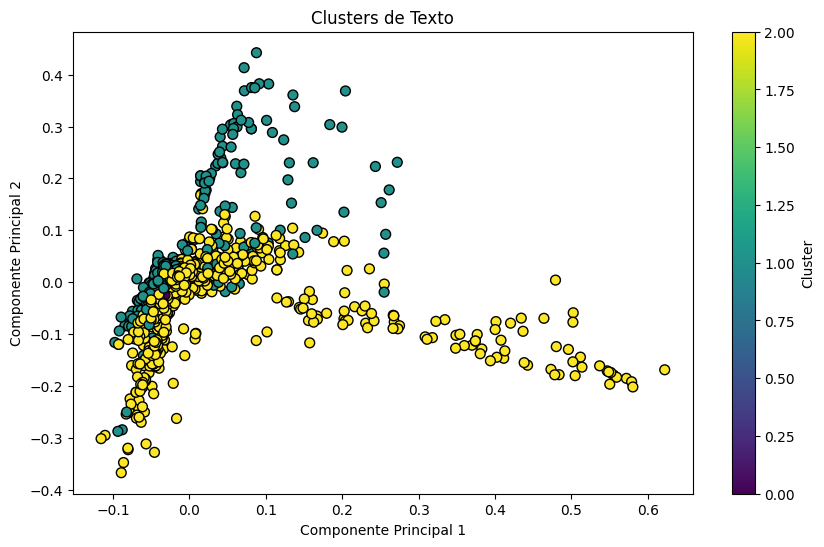

                                                   text  cluster
0     - ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...        2
1     - ¿Cuál es el mejor portero del mundial? \n- E...        2
2     El otro día unas chicas llamarón a mi puerta y...        2
3     - Andresito, ¿qué planeta va después de Marte?...        2
4     - ¿Por qué Bob Esponja no va al gimnasio? \n- ...        2
...                                                 ...      ...
2414  Una mujer en la consulta del médico.\n-Hola do...        2
2415  Error 0094782: No se detecta ningún teclado pu...        2
2416  Una chica entra a una iglesia con un buen esco...        1
2417  Un hombre va a hablar con su jefe:\n-Hola veng...        1
2418  Llega una pareja a un restaurante el señor muy...        1

[2419 rows x 2 columns]


In [13]:
def preprocess_text(text):
    # Aquí puedes agregar más pasos de limpieza si es necesario
    text = text.lower()  # Convertir a minúsculas
    # ... (eliminar puntuación, etc.)
    return text


df['cleaned_text'] = df['text'].apply(preprocess_text)

# Usar TfidfVectorizer con stop words en español
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X = vectorizer.fit_transform(df['cleaned_text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

# Reducir la dimensionalidad a 2D para la visualización
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Agregar las coordenadas reducidas al DataFrame
df['x'] = X_reduced[:, 0]
df['y'] = X_reduced[:, 1]

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'],
            cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters de Texto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# (Opcional) Mostrar los clusters
print(df[['text', 'cluster']])

In [14]:
# Imprimir las palabras más importantes de cada cluster
words = vectorizer.get_feature_names_out()
for cluster in range(kmeans.n_clusters):
    # Sumar los vectores TF-IDF de los documentos en este cluster
    cluster_docs = X[df['cluster'] == cluster]
    cluster_mean = np.mean(cluster_docs.toarray(), axis=0)

    # Obtener las palabras con el mayor valor en el vector promedio
    # 10 palabras más importantes
    top_indices = cluster_mean.argsort()[-10:][::-1]
    print(f'Cluster {cluster}:')
    for i in top_indices:
        print(f'  {words[i]}: {cluster_mean[i]:.4f}')

Cluster 0:
  jardinero: 0.4107
  podamos: 0.2350
  disfrutemos: 0.2055
  dejen: 0.1096
  plantado: 0.1096
  ahorraríamos: 0.0932
  supieses: 0.0932
  dineral: 0.0932
  colmo: 0.0807
  muela: 0.0773
Cluster 1:
  hombre: 0.0744
  jaimito: 0.0445
  pregunta: 0.0399
  señor: 0.0359
  telón: 0.0233
  entra: 0.0197
  camarero: 0.0197
  responde: 0.0177
  padre: 0.0176
  mujer: 0.0174
Cluster 2:
  mamá: 0.0172
  mujer: 0.0169
  doctor: 0.0146
  hijo: 0.0134
  marido: 0.0120
  casa: 0.0086
  años: 0.0082
  tienes: 0.0081
  amor: 0.0080
  oye: 0.0076


Mejor resultado, pero un poco confuzo todavia.

# Modelo 1

Un modelo de temas con NMF (Non-negative Matrix Factorization) es una técnica que se utiliza para encontrar temas ocultos en un conjunto de documentos.

¿Cómo funciona en palabras simples?
1. Descomposición de la matriz:
    - Piensa que cada documento es como una bolsa de palabras. El modelo toma todos estos documentos y las palabras que contienen y crea una gran tabla (matriz) donde cada fila es un documento y cada columna es una palabra.
    - Luego, el modelo NMF descompone esta tabla en dos partes más pequeñas:
        - Una parte que nos dice qué palabras están relacionadas con cada tema.
        - Otra parte que nos dice qué temas están presentes en cada documento.
2. Temas ocultos:
    - El modelo NMF encuentra grupos de palabras que tienden a aparecer juntas en los documentos. Cada grupo de palabras representa un tema.
    - Por ejemplo, en un conjunto de noticias, el modelo podría identificar temas como "deportes" con palabras como "equipo", "partido", "jugador", y otro tema sobre "economía" con palabras como "mercado", "dinero", "finanzas".
3. Asignación de temas:
    - Una vez que el modelo ha encontrado los temas, puede decirte qué temas son los más importantes en cada documento. Por ejemplo, puede indicar que un documento trata en un 70% de "deportes" y en un 30% de "economía".


In [15]:
def display_topics(H, feature_names, no_top_words):
    '''
    Display the topics generated by the NMF model (without documents)
    '''
    for topic_idx, topic in enumerate(H):
        print(' ')
        print('Topic %d:' % (topic_idx))
        print(' '.join([(feature_names[i] + ' (' + str(topic[i].round(2)) + ')')
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [19]:
# Defino argumentos
no_topics = 4
no_top_words = 10

# Inicializacion del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=spanish_stop_words)

# Ajuste y transformación del vectorizador TF-IDF
tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Obtención de los nombres de las características (palabras):
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Ejecución del modelo NMF:
nmf_model = NMF(n_components=no_topics, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Obtención de las matrices de temas y documentos
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

print('NMF Topics')
display_topics(nmf_H, tfidf_feature_names, no_top_words)
print('--------------')

NMF Topics
 
Topic 0:
mujer (1.1) hombre (1.08) marido (0.55) casa (0.47) pregunta (0.41) borracho (0.37) señor (0.35) contesta (0.33) amigo (0.32) responde (0.31)
 
Topic 1:
mamá (1.84) hijo (0.27) escuela (0.15) niño (0.14) colegio (0.12) tienes (0.12) mañana (0.12) madre (0.11) cállate (0.1) hija (0.09)
 
Topic 2:
doctor (1.87) médico (0.28) grave (0.17) señora (0.16) consulta (0.14) operación (0.14) duele (0.14) pasa (0.11) siento (0.1) punto (0.09)
 
Topic 3:
jaimito (1.25) hijo (0.75) padre (0.74) papá (0.72) mama (0.38) pregunta (0.37) niño (0.25) madre (0.23) papa (0.21) maestra (0.2)
--------------


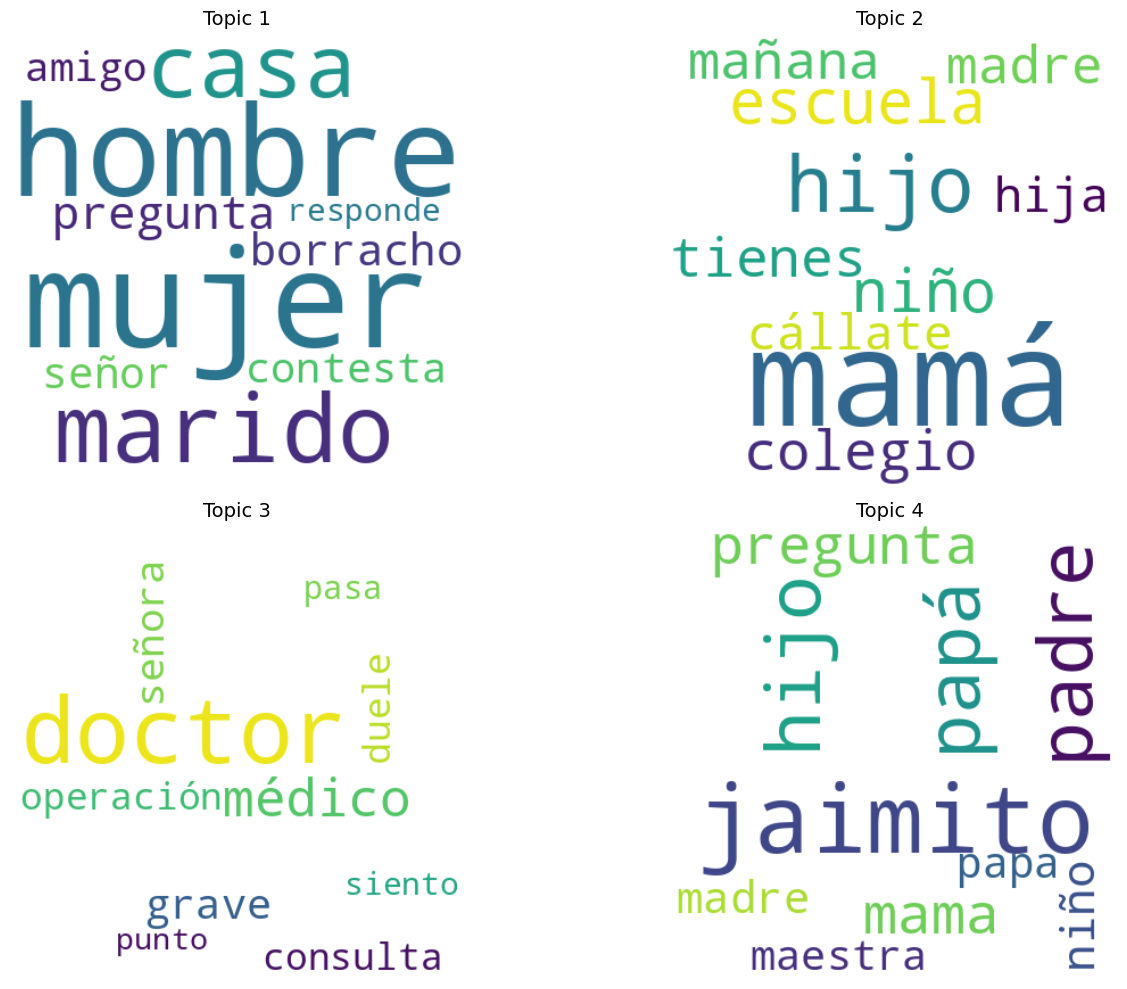

In [20]:
def plot_wordclouds(H, feature_names, no_top_words, no_topics):
    '''
    Generate word clouds for each topic
    '''
    fig, axes = plt.subplots(2, int(np.ceil(no_topics / 2)), figsize=(15, 10))
    axes = axes.flatten()

    for topic_idx, topic in enumerate(H):
        # Obtener las palabras principales y sus pesos
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        # Crear un diccionario de palabras y pesos
        word_freq = {top_features[i]: weights[i]
                     for i in range(len(top_features))}

        # Generar la nube de palabras
        wordcloud = WordCloud(
            width=400, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Mostrar la nube en el subplot correspondiente
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=14)

    plt.tight_layout()
    plt.show()


# Graficar nubes de palabras para los tópicos
plot_wordclouds(nmf_H, tfidf_feature_names, no_top_words, no_topics)

# Modelo 2

Cargaremos el módulo de español en espacios espaciosos e intentaremos obtener la parte del discurso (POS) de cada palabra y otra información.

In [21]:
import spacy
nlp = spacy.load('es_core_news_sm')
nlp

# Using scikit-learn for vectorization
Una forma sencilla de convertir un documento en números (para que se puedan aplicar fácilmente algoritmos) es contar las palabras que contiene. Normalmente es mejor considerar sólo palabras que tengan un significado fuerte, y en nuestro caso (intentar clasificar documentos) es importante encontrar palabras que sean lo suficientemente comunes, para convertirlas en "características", pero no demasiado comunes, para que puedan ayudarnos. clasificar los documentos. En sklearn existen varios métodos para contar palabras de documentos. 

# Filtering words

Intentemos quedarnos sólo con palabras con significado real. Una forma clásica de hacerlo es eliminar todas las stopword, pero aquí podemos aprovechar la información adicional y conservar solo los sustantivos, verbos, adjetivos y adverbios.

Antiguamente se procesaban las palabras con una lematizadora (que elimina la terminación "s" y algunos otros trucos), pero vamos a normalizar las palabras usando su lema.

In [22]:
def keep_only_content_words(s):
    processed = nlp(s)
    result = [token.lemma_ for token in processed if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV')]
    return ' '.join(result)

In [23]:
df['filtered_text'] = df['text'].apply(keep_only_content_words)
df.head()

,id,text,keywords,funny,category,len,Palabras por chiste,cluster,x,y,cleaned_text,filtered_text
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,17,2,-0.016310,0.007510,"- ¡rápido, necesitamos sangre!\n- yo soy 0 pos...",rápido necesitar positivo mucho mal necesitar ...
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,13,2,-0.012207,0.010677,- ¿cuál es el mejor portero del mundial? \n- e...,mejor portero mundial evidente
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,25,2,-0.011217,0.006671,el otro día unas chicas llamarón a mi puerta y...,día chica llamarón puerta pedir pequeño donaci...
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,11,2,-0.008605,0.033861,"- andresito, ¿qué planeta va después de marte?...",planeta después señoritar
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,14,2,-0.014500,0.011119,- ¿por qué bob esponja no va al gimnasio? \n- ...,no ir gimnasio ya cuadrado


# tf-idf
Una manera de generar valores numéricos de las palabras es usar tf-idf (frecuencia de términos, frecuencia inversa de documentos). Apliquemoslo a nuestra bolsa_de_palabras.

# Real vectorizer with tf-idf

Encontraresmos las 500 palabras mas comunes que aparecen en menos de 200 chistes. Y las usaremos para vectorizar los chistes.

In [24]:
# TfidfVectorizer = CountVectorizer + TFidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
max_jokes_with_that_word = 200

tfidf_vectorizer = TfidfVectorizer(max_df=max_jokes_with_that_word, max_features=500)
bag_of_words = tfidf_vectorizer.fit_transform(df.filtered_text)

important_words = tfidf_vectorizer.get_feature_names_out()

print(', '.join(important_words))

abajo, abogado, abrir, abuela, abuelo, acabar, aceptar, acerca, acercar, acostar, acto, acuerdo, además, agua, ahora, ahí, alcanzar, allí, alto, alumno, amante, amiga, amigo, amor, anciana, animal, antes, aparecer, apuesta, aquí, arriba, asustado, así, autobús, avión, ayer, ayudar, año, aún, bajar, bajo, banco, bar, barco, barra, baño, beber, bebé, bien, blanco, boca, boda, bola, borracho, botella, brazo, buen, buena, bueno, burro, buscar, caballo, cabeza, cabo, cabra, cabrón, caer, café, cagar, caja, calle, cama, camarero, cambiar, caminar, camino, campo, capitán, cara, cariño, carretera, casa, casado, casar, casi, caso, catalán, cena, cerdo, cerrar, cerveza, chica, chico, chino, chiste, chófer, cielo, claro, clase, cliente, cobrar, coche, cocina, coger, colegio, colmo, colocar, color, comar, comentar, comenzar, comer, comida, compra, comprar, conocer, conseguir, consulta, contar, contento, contesta, contestar, continuar, copa, correr, cortar, cosa, costar, creer, cuanto, cuarto, cuen

# Train a ML algorithm
Ahora tenemos 500 funciones por documento (broma). Vamos a entrenar un algoritmo de ML para aprender las 7 categorías proporcionadas.

Generalmente la colección de muestras (documentos, chistes) con sus características se llama "X", y el objetivo se llama "y" (en nuestro caso, las categorías). Primero convertiremos las categorías a números.

In [25]:
# y : let's make category a number
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df.category)

In [26]:
df['y'] = y

df.head()

,id,text,keywords,funny,category,len,Palabras por chiste,cluster,x,y,cleaned_text,filtered_text
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,17,2,-0.016310,2,"- ¡rápido, necesitamos sangre!\n- yo soy 0 pos...",rápido necesitar positivo mucho mal necesitar ...
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,13,2,-0.012207,2,- ¿cuál es el mejor portero del mundial? \n- e...,mejor portero mundial evidente
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,25,2,-0.011217,2,el otro día unas chicas llamarón a mi puerta y...,día chica llamarón puerta pedir pequeño donaci...
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,11,2,-0.008605,3,"- andresito, ¿qué planeta va después de marte?...",planeta después señoritar
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,14,2,-0.014500,2,- ¿por qué bob esponja no va al gimnasio? \n- ...,no ir gimnasio ya cuadrado


Ahora dividiremos X en un conjunto de entrenamiento y un conjunto de prueba. Por lo tanto, entrenaremos el algoritmo ML SÓLO con el conjunto de trenes y luego veremos qué tan bien funciona con el conjunto de pruebas.

In [27]:
# Split products in train (75%) and test (25%)
X = bag_of_words
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1814, 500), (605, 500), (1814,), (605,))

Entonces tenemos un conjunto de entrenamiento con 1814 chistes y 500 funciones por chiste, y un conjunto de prueba de 605 chistes.

# Train a Random Forest
Un Random Forest es un algoritmo de aprendizaje automático que se utiliza para clasificación y regresión. En el contexto de topic modeling, aunque no es el método típico (como LDA o NMF), puede ser útil para tareas relacionadas. Entonces:

- Conjunto de árboles: Random Forest crea un "bosque" de muchos árboles de decisión. Cada árbol toma decisiones basadas en diferentes subconjuntos de datos y características.

- Toma de decisiones: Cuando se le presenta un nuevo dato (por ejemplo, un texto), cada árbol da su propia "opinión" sobre a qué tema pertenece. Luego, se hace un "voto" para determinar el tema final, basándose en las decisiones de todos los árboles.

- Robustez: Al combinar las decisiones de muchos árboles, Random Forest es más robusto y menos propenso a errores que un solo árbol. Esto ayuda a mejorar la precisión en la identificación de temas.

- Características: Puedes usar Random Forest para identificar las palabras o características más importantes que ayudan a clasificar los textos en temas. Esto puede dar una idea de qué palabras son más relevantes para cada tema.

Vamos a entrenar un `RandomForestClassifier` con 200 árboles y veremos si podemos superar la puntuación base (es decir, supongamos que todos los chistes están en la categoría "otros").

In [28]:
from sklearn.ensemble import RandomForestClassifier

number_of_trees = 200
clf = RandomForestClassifier(n_estimators=number_of_trees, random_state=1)
clf.fit(X_train, y_train)

base_score = 0.318
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f'Base score (all to "otros"): {base_score}')
print(f'Train set score: {train_score}')
print(f'Test set score: {test_score}' )

Base score (all to "otros"): 0.318
Train set score: 0.9729878721058435
Test set score: 0.484297520661157


¡Nada mal! Hemos mejorado 16 puntos el marcador. Sin embargo, el resultado dista mucho de ser perfecto, probablemente debido al tamaño reducido de los chistes.

Comprobemos qué características (palabras) fueron las más relevantes para decidir la categoría de un chiste.

In [29]:
# Feature importance
importances = pd.DataFrame(data=clf.feature_importances_, index=tfidf_vectorizer.get_feature_names_out(), columns=['importance'])
importances.sort_values(['importance'], ascending=False).head(10)

,importance
amigo,0.017681
perro,0.016756
marido,0.016318
lepero,0.013880
hijo,0.012162
amor,0.010371
vasco,0.008356
doctor,0.008334
contesta,0.007995
animal,0.007983


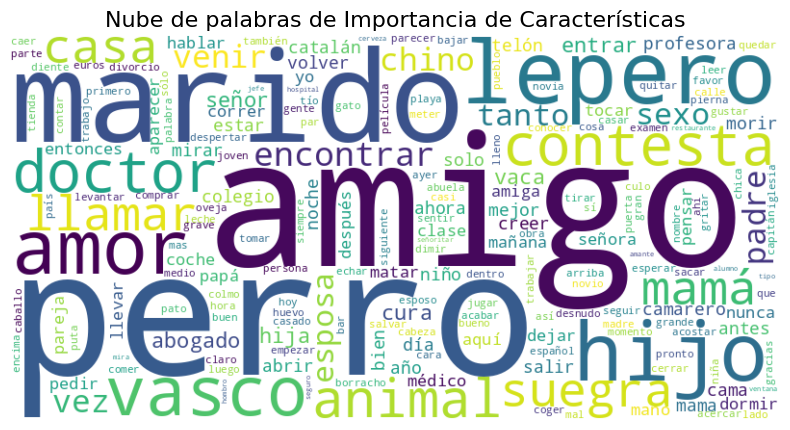

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame 'importances' con las importancias


def plot_importance_wordcloud(importances):
    '''
    Generate a word cloud from feature importances
    '''
    # Convertir el DataFrame a un diccionario
    word_freq = importances['importance'].to_dict()

    # Generar la nube de palabras
    wordcloud = WordCloud(
        width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # No mostrar ejes
    plt.title('Nube de palabras de Importancia de Características', fontsize=16)
    plt.show()


# Graficar la nube de palabras de importancias
plot_importance_wordcloud(importances)

Intenta mejorar el resultado del algoritmo ML.

Puedes consultar 3 alternativas:

En el apartado "Filtrar palabras", elige usar el lema o no, y diferentes POS.
En la sección "Vectorizador real con tf-idf", considere más de 500 palabras.
En la sección "Entrenar un bosque aleatorio", explore las opciones de RandomForestClassifier (consulte la documentación).

# Modelo 3

Echando un segundo vistazo a las categorías proporcionadas, parece que no son realmente buenas (especialmente si miramos "otros").

Existen varias técnicas no supervisadas para, dada una colección de documentos, encontrar grupos de temas.

Probaremos aquí `LaternDirichletAllocation`, o LDA, que es una tecnología clásica pero generalmente es difícil trabajar con ella, ya que necesita muchos ajustes. Por ejemplo, elegir el número de temas.

In [36]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

number_of_topics = 9
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

lda.fit(X)
topics = lda.transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
            

print("\nTopics in LDA model:")
print_top_words(lda, tfidf_vectorizer.get_feature_names_out(), 8)


Topics in LDA model:
Topic #0: año hija niño amor rubio creer tonto sexo
Topic #1: venir euros amigo mejor tocar yo sacar oveja
Topic #2: llamar telón abrir película cerrar nombre hijo puta
Topic #3: morir día verdad mar bien lepero capitán llevar
Topic #4: tanto perro feo gustar matar chiste vivir novio
Topic #5: marido esposa borracho contesta casa mano calle dormir
Topic #6: doctor señor huevo antes quedar bar inglés salir
Topic #7: mamá hijo padre papá chino madre cura escuela
Topic #8: mañana nunca médico suegra ayer marido camarero diferencia


Algunos de los temas tienen sentido, como el tema 5 (madre y escuela) o el tema 8 (padre), pero otros no muestran un tema claro y comprensible.

Intentemos visualizar los pesos de cada tema.

In [39]:
jokes_with_topics_weights = pd.concat([df, pd.DataFrame(
    topics, columns=[f'topic_{x}' for x in range(0, 9)])], axis=1)
jokes_with_topics_weights.head()

,id,text,keywords,funny,category,len,Palabras por chiste,cluster,x,y,...,filtered_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros,105,17,2,-0.016310,2,...,rápido necesitar positivo mucho mal necesitar ...,0.042313,0.042331,0.042313,0.042315,0.042314,0.661420,0.042369,0.042313,0.042313
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros,70,13,2,-0.012207,2,...,mejor portero mundial evidente,0.055563,0.555511,0.055558,0.055577,0.055556,0.055557,0.055556,0.055562,0.055561
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros,131,25,2,-0.011217,2,...,día chica llamarón puerta pedir pequeño donaci...,0.248524,0.030834,0.030844,0.030837,0.222186,0.030864,0.030830,0.224434,0.150646
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones,69,11,2,-0.008605,3,...,planeta después señoritar,0.046530,0.046524,0.046524,0.046520,0.627793,0.046526,0.046533,0.046522,0.046528
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros,69,14,2,-0.014500,2,...,no ir gimnasio ya cuadrado,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


Busquemos algunos ejemplos sólidos del tema n.° 1.

In [40]:
topic1 = jokes_with_topics_weights[jokes_with_topics_weights['topic_1']>0.80]
topic1['text'].apply(lambda s: print(s+'\n-----\n'))

Un transportista llevaba una partida de pingüinos hacia el zoológico, cuando a medio camino se le estropea el camión refrigerado. Preocupado, trata de reparar el problema pero ve pasar un camión repartidor de leche y consigue que se detenga. 

Entonces le dice al lechero: 
- Mira, te voy a dar 500 euros para que me hagas el favor de llevar estos pingüinos al zoológico.

El lechero acepta el dinero y se lleva con gusto los pingüinos en su camión refrigerado.
Mientras tanto, el transportista logra arreglar el daño, y de inmediato enfila hacia el zoológico.

En cuanto llega, ve salir al lechero, con los pingüinos detrás de él, en fila. El chófer le pregunta al lechero:

- ¿A donde vas con los pingüinos?
El lechero se lo queda mirando y le responde:

- Ya los llevé al zoológico, pero como me sobró dinero, ahora los pensaba llevar al cine..."
-----

Llega uno de Lepe a una empresa a pedir trabajo y lo pasan al Dpto. de Recursos Humanos. Allí le indican que van a comenzar por hacerle algunas

20      None
498     None
516     None
935     None
962     None
1094    None
1141    None
1462    None
1505    None
1746    None
Name: text, dtype: object

Al parecer no hay un tema claro en común.

intente explorar otros temas, cambie la cantidad de temas o modifique los hiperparámetros LDA.